In [154]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict,GridSearchCV
from sklearn.metrics import roc_auc_score,balanced_accuracy_score

In [155]:
#! pip install umap-learn

#### Display options

In [156]:
pd.set_option('display.max_row', 25)
pd.set_option('display.max_column', 25)

## First approach (just concatenate the prediction on the left and on the right side)

#### Load the prediction of presence of the PCS on the left hemisphere (HCP dataset)

In [157]:
HCP_binary_pred_left_PCS = pd.read_csv('/neurospin/dico/adufournet/Runs/04_Heritability_Left_PCS_HCP/Heritability/data/HCP_binary_pred_left_PCS.csv')
HCP_binary_pred_left_PCS

,IID,Pred
0,100206,0
1,100307,1
2,100408,1
3,100610,0
4,101006,0
...,...,...
1109,992774,0
1110,993675,1
1111,994273,0
1112,995174,1


#### Load the prediction of presence of the PCS on the right hemisphere (HCP dataset)

In [158]:
HCP_binary_pred_right_PCS = pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Heritability/data/HCP_binary_pred_PCS.csv")

#### Compute the asymmetry

In [159]:
HCP_asymmetry_PCS = abs(HCP_binary_pred_left_PCS.Pred - HCP_binary_pred_right_PCS.Pred)
HCP_asymmetry_PCS = pd.concat([HCP_binary_pred_left_PCS['IID'],HCP_asymmetry_PCS], axis=1)
HCP_asymmetry_PCS

,IID,Pred
0,100206,1
1,100307,0
2,100408,1
3,100610,0
4,101006,0
...,...,...
1109,992774,1
1110,993675,1
1111,994273,0
1112,995174,0


#### Save the asymmetry prediction on neurospin

In [160]:
HCP_asymmetry_PCS.to_csv("/neurospin/dico/adufournet/Runs/05_Heritability_Asymmetry_PCS_HCP/Heritability/data/HCP_asymmetry_PCS.csv", index=False)

## Second approach (Concatenate the right and left latent spaces, predict the asymmetry from it)

##### Load the embeddings representations for the ACCP (which is the training dataset) and the HCP dataset (which will be the input for the trained SVM classifier)

In [161]:
embeddings_ACCP_left= pd.read_csv("/neurospin/dico/adufournet/Runs/04_Heritability_Left_PCS_HCP/Program/Output/2024-05-13/09-33-29_206/acc_epoch60_embeddings/full_embeddings.csv")#, index_col=0)
embeddings_ACCP_right= pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Input/ACCpatterns_cingulate_full_embeddings.csv")
embeddings_ACCP = pd.concat([embeddings_ACCP_left,embeddings_ACCP_right.drop('ID', axis=1)], axis=1)
embeddings_ACCP

,ID,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
0,1-03HUBJO_t0,-10.300048,-8.993956,-24.014177,-22.748718,-20.079226,10.081562,-35.838430,-5.443741,-0.482752,11.556986,-8.657738,...,2.882060,-24.831553,-9.197613,-5.711463,-2.754603,-14.768034,17.421337,-33.757954,-2.704032,6.627081,-0.086178,23.621847
1,1-08ANDTI_t0,17.782938,-21.937262,-25.368660,5.567630,-42.060616,16.843365,12.600588,-10.436407,5.698798,8.553762,-15.713575,...,-2.165201,-25.279970,19.806355,-18.962173,15.065896,12.606016,10.264750,-11.282650,-15.794517,-1.264829,-1.585922,13.012749
2,1-11LEBJO_t0,-36.685577,5.157880,2.363987,-22.430391,-11.315966,13.808375,-49.053246,22.700457,-8.459773,12.038797,10.005174,...,1.524285,13.583164,10.764001,-33.918860,24.169624,18.739822,12.445322,23.753778,-24.569492,28.203157,-35.001040,5.951211
3,1-15LEHMI_t0,-16.128769,14.951199,-14.732849,5.576864,-21.033754,-10.399233,-45.814720,-26.131533,-27.402475,28.106800,-20.567886,...,-3.302573,-19.355429,4.560497,-19.082740,2.385815,12.654943,15.073609,-8.142779,-35.249516,-6.564681,-18.242151,-6.322456
4,1-17COLMA_t0,-12.741240,-20.531580,-7.063102,15.749422,-26.560053,2.146704,-26.149153,9.108587,-27.432632,32.134678,-5.934505,...,-2.317983,-25.239199,12.845156,11.860508,-7.861401,-8.461282,-8.631458,-9.310070,-5.761762,-24.695215,3.482464,-27.098180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,sub-inhibition25_ses-pretraining_T1w,-46.927147,-1.012615,39.200928,1.790302,-8.091936,22.930313,-56.579040,-5.073290,5.894837,17.353119,22.214405,...,-13.238676,4.240377,-47.951683,-5.288082,-19.935062,-10.275241,2.072381,-1.254634,-17.392796,22.209047,-30.299700,8.921869
337,sub-inhibition26_ses-pretraining_T1w,-31.228481,4.233710,10.857832,9.516086,0.792597,-30.693531,29.924980,26.852715,28.574594,8.175515,8.701328,...,-3.497534,1.546935,4.920863,-18.125204,1.087955,25.540407,19.166320,2.615173,-22.028465,16.422207,-15.004441,-15.991891
338,sub-inhibition28_ses-pretraining_T1w,-9.259340,10.269464,-4.369337,11.152019,-2.214729,-15.954047,18.052050,-21.549326,9.965367,5.791976,-1.654170,...,-19.229967,-5.518608,-7.411876,-5.617465,8.482850,12.970094,4.825340,7.096434,-18.960564,32.096100,-16.318506,-4.181726
339,sub-inhibition29_ses-pretraining_T1w,0.172009,-14.655333,-21.127450,8.332311,-21.689453,15.461191,-2.140106,-1.453473,18.745277,20.302645,25.477022,...,-31.701206,-5.535340,12.420484,-15.854844,-0.468121,15.632000,4.523982,20.061520,-1.616202,3.718000,-5.929497,2.169901


In [162]:
(embeddings_ACCP_left.ID == embeddings_ACCP_right.ID).sum()

341

In [163]:
labels_ACCP = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/subjects_labels.csv")
labels_ACCP = labels_ACCP[['long_name','Left_PCS', 'Right_PCS']]#,'PCS_asymetry']]

In [164]:
def encoder(df, columns):
    for col in columns:
        code = {'present':1,
                'absent':0}
        df[col] = df[col].map(code)
    return df

encoder(labels_ACCP, ['Left_PCS', 'Right_PCS']) 

,long_name,Left_PCS,Right_PCS
0,nih_chp_04701_t1,1,0
1,nih_chp_01534_t1,1,1
2,nih_chp_04623_t1,1,1
3,nih_chp_01503_t1,0,0
4,nih_chp_00404_t1,1,1
...,...,...,...
376,a0005_t1_s03,0,1
377,a0006_t1_s03,1,0
378,a0001_t1_s03,1,1
379,a0016_t1_s03,0,1


In [476]:
labels_ACCP['Asymmetry'] = abs(labels_ACCP.Left_PCS - labels_ACCP.Right_PCS)
labels_ACCP['Two_PCS'] = labels_ACCP.Left_PCS & labels_ACCP.Right_PCS
labels_ACCP['Zero_PCS'] = (1-labels_ACCP.Left_PCS) & (1-labels_ACCP.Right_PCS)
labels_ACCP['Left_without_Right_PCS'] = (labels_ACCP.Left_PCS) & (1-labels_ACCP.Right_PCS)
labels_ACCP['Right_without_Left_PCS'] = (1-labels_ACCP.Left_PCS) & (labels_ACCP.Right_PCS)
labels_ACCP

,long_name,Left_PCS,Right_PCS,Asymmetry,Two_PCS,Zero_PCS,Left_without_Right_PCS,Right_without_Left_PCS
0,nih_chp_04701_t1,1,0,1,0,0,1,0
1,nih_chp_01534_t1,1,1,0,1,0,0,0
2,nih_chp_04623_t1,1,1,0,1,0,0,0
3,nih_chp_01503_t1,0,0,0,0,1,0,0
4,nih_chp_00404_t1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...
376,a0005_t1_s03,0,1,1,0,0,0,1
377,a0006_t1_s03,1,0,1,0,0,1,0
378,a0001_t1_s03,1,1,0,1,0,0,0
379,a0016_t1_s03,0,1,1,0,0,0,1


In [484]:
#(labels_ACCP['Asymmetry']==labels_ACCP['PCS_asymetry']).sum()
labels_ACCP.Asymmetry.sum()/len(labels_ACCP)
labels_ACCP['Right_without_Left_PCS'].sum() / len(labels_ACCP)

0.1679790026246719

In [485]:
embeddings_HCP_left = pd.read_csv("/neurospin/dico/adufournet/Runs/04_Heritability_Left_PCS_HCP/Program/Output/2024-05-13/09-33-29_206/hcp_epoch60_embeddings/full_embeddings.csv", index_col=0)
embeddings_HCP_right = pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Input/hcp_cingulate_full_embeddings.csv", index_col=0)
embeddings_HCP = pd.concat([embeddings_HCP_left,embeddings_HCP_right], axis=1)
embeddings_HCP

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,,,,,
100206,-5.876003,-0.845744,-12.204170,10.151408,-18.957836,-29.795780,12.937123,-7.214358,15.110987,10.792451,-7.787244,9.263735,...,15.884296,-10.469205,0.255839,-26.942001,9.252998,9.163906,6.532629,10.676800,-14.139249,0.045611,-35.327550,-13.927697
100307,-19.529308,-7.768003,-16.622694,15.692203,-32.981106,-20.219995,-20.074820,3.648118,4.962884,28.067015,7.735142,13.419550,...,14.628305,-5.092073,6.490175,-8.862627,13.441197,2.842024,6.585532,25.127434,-6.861317,15.825949,-23.992393,-9.157214
100408,-24.607979,2.905064,-9.724290,35.772090,-38.557724,5.821410,-11.363668,18.840570,-9.526131,34.880870,-6.178275,-7.339914,...,22.036820,4.887552,28.514357,-9.187751,-13.514122,-2.253131,2.700759,7.052255,-21.251228,-8.701427,-5.803285,-24.713255
100610,-8.027011,0.322856,-15.113009,3.927100,-22.753002,-6.738647,10.846553,47.801365,18.840824,19.917740,-4.696721,-15.373317,...,-12.174725,-18.633965,-14.625642,-21.709137,7.999446,23.296196,2.751116,-6.180230,-41.432198,0.679659,-29.611362,-17.983616
101006,-25.976790,-5.441645,-10.610805,-9.526792,14.037749,-4.063296,12.062643,-15.676752,12.239485,5.389635,8.132303,-29.955600,...,-15.340488,-10.146723,-17.744781,12.339481,5.968554,16.571490,7.573746,-6.312110,-21.530790,18.567806,-16.335620,3.381026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992774,17.165743,-36.441390,-22.935884,-14.686571,-9.867681,-7.135174,26.120441,-12.414014,16.909752,-9.952538,-22.462795,-1.405541,...,-6.833909,16.613867,2.221115,-4.456804,-3.220039,8.444373,4.747440,21.607277,-8.192159,10.038024,-6.542052,9.730474
993675,-37.006813,28.016909,8.215394,-3.528147,10.978013,-11.092725,-10.434095,10.676113,-4.587836,-6.940797,-5.100392,5.050050,...,-20.458132,-20.188393,-8.345625,-4.067662,-9.169641,-1.396057,6.299828,0.995704,-13.701394,-9.113794,-8.200265,-12.685424
994273,-35.012260,7.191190,18.193295,-24.775734,10.159574,-2.134576,-51.921300,11.000490,4.337312,6.170895,22.973560,0.902636,...,-3.469933,-11.665941,-10.113407,-2.895253,9.940379,15.714289,13.029745,-6.024564,-18.540964,5.411079,-20.089376,-16.943203


### Chose here the target y you want to work with

In [529]:
# 'Asymmetry','Left_PCS','Right_PCS','Two_PCS','Zero_PCS', 'Right_without_Left_PCS', 'Left_without_Right_PCS'
target = 'Left_without_Right_PCS'

#### Scaler

In [530]:
ebdd_lbl_ACCP = embeddings_ACCP.set_index('ID').join(labels_ACCP.set_index('long_name'))
X = ebdd_lbl_ACCP.drop(['Asymmetry','Left_PCS','Right_PCS','Two_PCS','Zero_PCS','Right_without_Left_PCS','Left_without_Right_PCS'], axis=1)
y = ebdd_lbl_ACCP[target] #change it if you want to test with all the dimensions for only one hemisphere

The scaler is fited on the ACCP database at first, it transforms it and then transforms the HCP dataset.
Is it better to fit one everything and transform everything at once ?

In [531]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
scl_bdd_hcp = scaler.transform(embeddings_HCP)
X.shape ,scl_bdd_hcp.shape, y.shape

((341, 512), (1114, 512), (341,))

#### SVC model, training on the ACCP database

In [532]:
'''
parameters = {'kernel':('linear', 'rbf', 'poly'),'C' : [0.0001, 0.001, 0.01,0.1,1,10,100,1000], 'degree': [1,2,3]}
svc = SVC(class_weight='balanced')
clf = GridSearchCV(svc, parameters, cv=5,)
clf.fit(X, y)
'''

"\nparameters = {'kernel':('linear', 'rbf', 'poly'),'C' : [0.0001, 0.001, 0.01,0.1,1,10,100,1000], 'degree': [1,2,3]}\nsvc = SVC(class_weight='balanced')\nclf = GridSearchCV(svc, parameters, cv=5,)\nclf.fit(X, y)\n"

In [533]:
#clf.best_estimator_

In [534]:
'''
from sklearn.neural_network import MLPClassifier

parameters = {'alpha': [1e-2,1e-1,1,10,100,1000,1e4], 
              'hidden_layer_sizes': [(50), (5,5), (30), (50,5), (70), (10,5,2)],
              'max_iter': [300,450]}
mlp = MLPClassifier(activation='relu')
clf = GridSearchCV(mlp, parameters, cv=7,)
clf.fit(X, y)
'''

"\nfrom sklearn.neural_network import MLPClassifier\n\nparameters = {'alpha': [1e-2,1e-1,1,10,100,1000,1e4], \n              'hidden_layer_sizes': [(50), (5,5), (30), (50,5), (70), (10,5,2)],\n              'max_iter': [300,450]}\nmlp = MLPClassifier(activation='relu')\nclf = GridSearchCV(mlp, parameters, cv=7,)\nclf.fit(X, y)\n"

In [535]:
#clf.best_estimator_

In [536]:
model = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

In [537]:
# model = MLPClassifier(alpha=100, hidden_layer_sizes=5, max_iter=250)

In [538]:
outputs = {}
val_pred = cross_val_predict(model, X, y, cv=5)
auc = roc_auc_score(y, val_pred)
outputs['labels_pred'] = val_pred
outputs['auc'] = auc
outputs['balanced_accuracy_score'] = balanced_accuracy_score(y, val_pred)

In [539]:
outputs['auc'], outputs['balanced_accuracy_score']

(0.7044665928386858, 0.7044665928386858)

La valeur d'auc ci dessous n'est pas fiable car on s'entraîne sur l'ensemble du modèle pour tester sur l'ensemble du modèle.

In [540]:
model.fit(X,y)
roc_auc_score(y,model.predict_proba(X)[:,1]), balanced_accuracy_score(y, model.predict(X))

(0.8837578442229606, 0.8322628276116648)

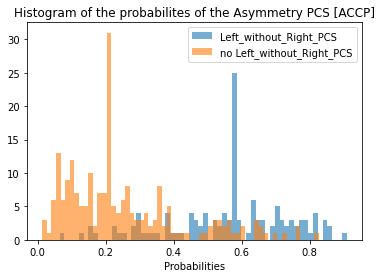

In [541]:
plt.hist(model.predict_proba(X)[y==1,1], bins=60, alpha=0.6, label=f'{target}')
plt.hist(model.predict_proba(X)[y==0,1], bins=60, alpha=0.6, label=f'no {target}')
plt.xlabel('Probabilities')
plt.title('Histogram of the probabilites of the Asymmetry PCS [ACCP]')
plt.legend()
plt.show()

In [542]:
float((model.predict(X) == (model.predict_proba(X)>0.5)[:,1]).sum())/len(X)

0.9149560117302052

#### Classification of the HCP embeddings

In [543]:
val_pred = model.predict(X=scl_bdd_hcp)

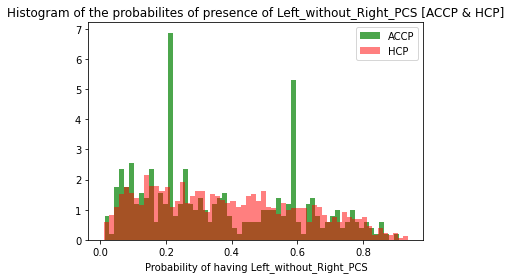

In [544]:
plt.hist(model.predict_proba(X)[:,1], bins=60, color='g', alpha=0.7, label='ACCP', density=True)
plt.hist(model.predict_proba(scl_bdd_hcp)[:,1], bins=60, color='red', alpha=0.5, label='HCP', density=True)
plt.xlabel(f'Probability of having {target}')
plt.title(f'Histogram of the probabilites of presence of {target} [ACCP & HCP]')
plt.legend()
plt.show()

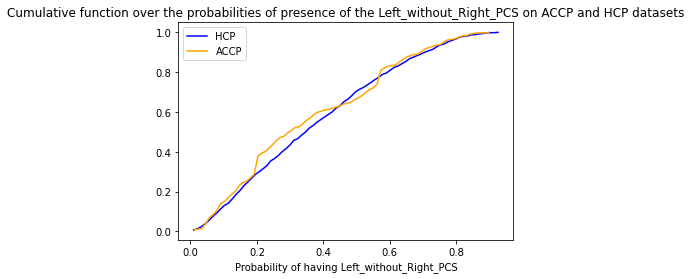

In [545]:
values_ACCP, base_ACCP = np.histogram(model.predict_proba(X)[:,1], bins=80)
cumulative_ACCP = np.cumsum(values_ACCP)
values_HCP, base_HCP = np.histogram(model.predict_proba(scl_bdd_hcp)[:,1], bins=80)
cumulative_HCP = np.cumsum(values_HCP)

plt.plot(base_HCP[:-1], cumulative_HCP/len(scl_bdd_hcp), c='blue', label='HCP')
plt.plot(base_ACCP[:-1], cumulative_ACCP/len(X), c='orange', label='ACCP')
plt.xlabel(f'Probability of having {target}')
plt.legend()
plt.title(f'Cumulative function over the probabilities of presence of the {target} on ACCP and HCP datasets')
plt.show()

#### SVM classification between ACCP and HCP datasets

In [546]:
scd_bdd_hcp = pd.DataFrame(scl_bdd_hcp, columns=embeddings_HCP.columns)
scd_bdd_hcp['Dataset'] = 0

scd_bdd_ACCP = pd.DataFrame(X,columns=embeddings_HCP.columns)
scd_bdd_ACCP['Dataset'] = 1

In [547]:
scd_bdd_HCP_ACCP = pd.concat([scd_bdd_hcp,scd_bdd_ACCP], axis=0)
scd_bdd_HCP_ACCP

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256,Dataset
0,0.239927,-0.224921,-0.675947,0.759515,-0.956935,-1.686962,0.917758,-0.099048,0.551403,-0.450550,-0.690937,0.095653,...,-0.263852,-0.387313,-1.644946,1.037354,0.579531,-0.036738,0.223121,-0.565826,-0.630988,-2.621130,-0.653645,0
1,-0.611324,-0.706184,-0.937171,1.111977,-2.116829,-1.085650,-0.845706,0.497010,-0.167517,0.776780,0.422909,0.393078,...,0.302055,-0.008871,-0.024336,1.361399,0.078629,-0.031831,1.307759,-0.048032,0.645575,-1.590091,-0.305347,0
2,-0.927968,0.035850,-0.529336,2.389300,-2.578083,0.549624,-0.380365,1.330667,-1.193960,1.260893,-0.575481,-1.092644,...,1.352344,1.328060,-0.053479,-0.724158,-0.325076,-0.392211,-0.048931,-1.071814,-1.338587,0.064379,-1.441109,0
3,0.105817,-0.143676,-0.847918,0.363574,-1.270841,-0.239086,0.806082,2.919835,0.815635,0.197787,-0.469169,-1.667582,...,-1.123138,-1.290661,-1.175879,0.940366,1.699275,-0.387540,-1.042137,-2.507606,-0.579697,-2.101189,-0.949772,0
4,-1.013310,-0.544447,-0.581747,-0.492257,1.772198,-0.071087,0.871044,-0.563405,0.347977,-0.834411,0.451408,-2.711213,...,-0.229913,-1.480002,1.876193,0.783234,1.166456,0.059843,-1.052035,-1.091704,0.867379,-0.893636,0.610082,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,-2.319516,-0.236523,2.363126,0.227647,-0.058194,1.623980,-2.795725,0.018439,-0.101495,0.015575,1.461902,-0.605856,...,1.284233,-3.313647,0.296082,-1.220952,-0.960692,-0.450504,-0.672430,-0.797303,1.161940,-2.163800,1.014625,1
337,-1.340740,0.128223,0.687480,0.719101,0.676664,-1.743337,1.825232,1.770318,1.505202,-0.636479,0.492240,-2.154838,...,1.000766,-0.104133,-0.854621,0.405617,1.877090,1.135257,-0.381970,-1.127111,0.693809,-0.772553,-0.804354,1
338,0.028984,0.547852,-0.212751,0.823166,0.427922,-0.817769,1.190992,-0.885652,0.186872,-0.805826,-0.250844,0.707851,...,0.257165,-0.852765,0.266556,0.977767,0.881106,-0.195119,-0.045615,-0.908843,1.961761,-0.892079,0.057918,1
339,0.617007,-1.185019,-1.203492,0.643798,-1.182873,1.154955,0.112348,0.217070,0.808866,0.225134,1.696019,-0.561314,...,0.255404,0.351116,-0.651109,0.285222,1.092017,-0.223076,0.927521,0.325137,-0.333908,0.052898,0.521657,1


In [548]:
from sklearn.model_selection import train_test_split

In [549]:
X_train, X_test, y_train, y_test = train_test_split(scd_bdd_HCP_ACCP.drop("Dataset", axis=1), scd_bdd_HCP_ACCP["Dataset"], test_size=0.01, random_state=40)

In [550]:
model2 = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

In [551]:
model2.fit(X_train,y_train)
val_predict = cross_val_predict(model2, X_train, y_train, cv=10)
auc = roc_auc_score(y_train, val_predict)
auc

0.8012757222681062

In [552]:
roc_auc_score(y_test, model2.predict_proba(X_test)[:,1])

0.9772727272727273

### Visualization (UMAP)

In [553]:
import umap

In [554]:
reducer = umap.UMAP()#random_state=5)
scd_bdd_ACCP[target] = y.values
scd_bdd_ACCP['Dataset'] = 'ACCP'
scd_bdd_ACCP['Prediction'] = model.predict(X)
scd_bdd_hcp[target] = -1
scd_bdd_hcp['Dataset'] = 'HCP'
scd_bdd_hcp['Prediction'] = model.predict(scl_bdd_hcp)

We fit the reducer only on the ACCP database, we concatenate then the two bases and we reduce the m together.

In [555]:
reducer.fit(scd_bdd_ACCP.drop([target,'Dataset','Prediction'], axis=1))
HCP_and_ACCP = pd.concat([scd_bdd_hcp, scd_bdd_ACCP], axis=0)
embedding2D_HCP_and_ACCP = reducer.transform(HCP_and_ACCP.drop([target,'Dataset','Prediction'], axis=1))

The first figure is made to observe the site effect between ACCP and HCP databases.

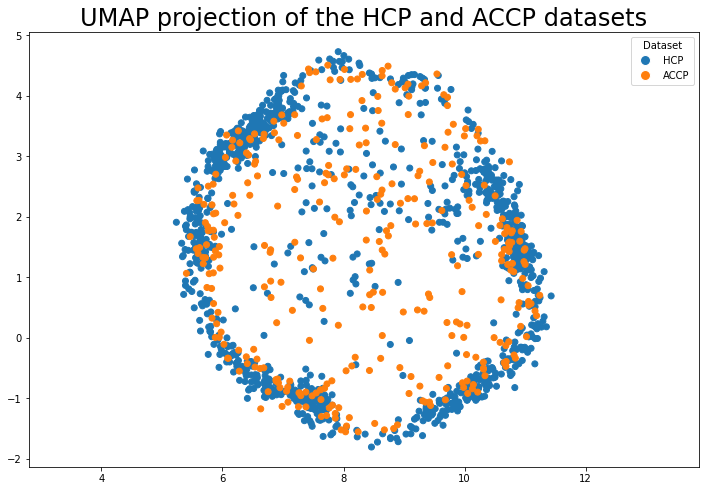

In [556]:
dataset_colors = [sns.color_palette()[0] if x == 'HCP' else sns.color_palette()[1] for x in HCP_and_ACCP['Dataset']]

plt.figure(figsize=(12, 8))
plt.scatter(
    embedding2D_HCP_and_ACCP[:, 0],
    embedding2D_HCP_and_ACCP[:, 1],
    c=dataset_colors)
plt.gca().set_aspect('equal', 'datalim')
unique_values = HCP_and_ACCP['Dataset'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=sns.color_palette()[i], markersize=10, 
                              label=f'{unique_values[i]}') 
                  for i in range(len(unique_values))]

plt.title('UMAP projection of the HCP and ACCP datasets', fontsize=24)
plt.legend(handles=legend_handles, title='Dataset', loc='best')
plt.show()

The second figure is made to point out the position of the people having the paracingular (1) (from the ACCP database), those who don't have it (0) (from the ACCP database), and those we don't know (-1) (from the HCP database).

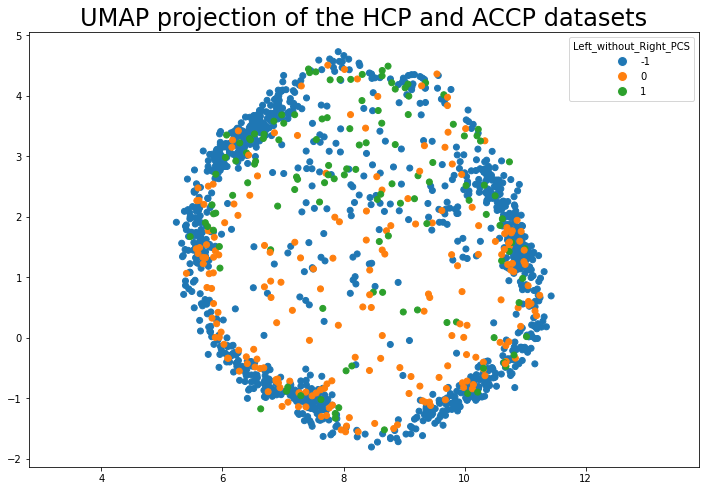

In [557]:
def plot_UMAP(ebb2D_dataset, initial_dataset, title, hue, coli=1):
    plt.figure(figsize=(12,8))
    plt.scatter(
        ebb2D_dataset[:, 0],
        ebb2D_dataset[:, 1],
        c=[sns.color_palette()[x+coli] for x in initial_dataset[hue]])
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=24)
    unique_values = initial_dataset[hue].unique()
    colors = [sns.color_palette()[x+coli] for x in unique_values]
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=colors[i], markersize=10, 
                                label=f'{unique_values[i]}') 
                    for i in range(len(unique_values))]
    plt.legend(handles=legend_handles, title=hue, loc='best')
    plt.show()

plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACCP datasets', target)

Then, the following figure highlights the two classes in the ACCP database.

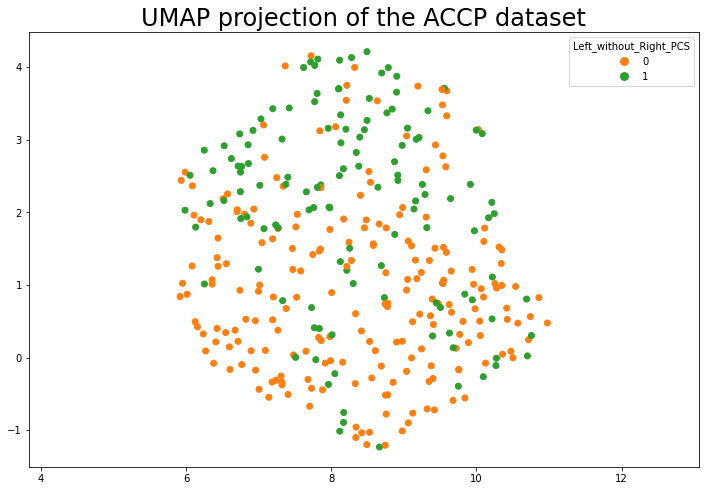

In [558]:
embedding2D_ACCP = reducer.transform(scd_bdd_ACCP.drop([target,'Dataset','Prediction'], axis=1))

plot_UMAP(embedding2D_ACCP, scd_bdd_ACCP, 'UMAP projection of the ACCP dataset', target)

We can do the same one by only keeping the 10 best ranked values given the SVM linear classification, on the ACCP database at first, and on the HCP then.

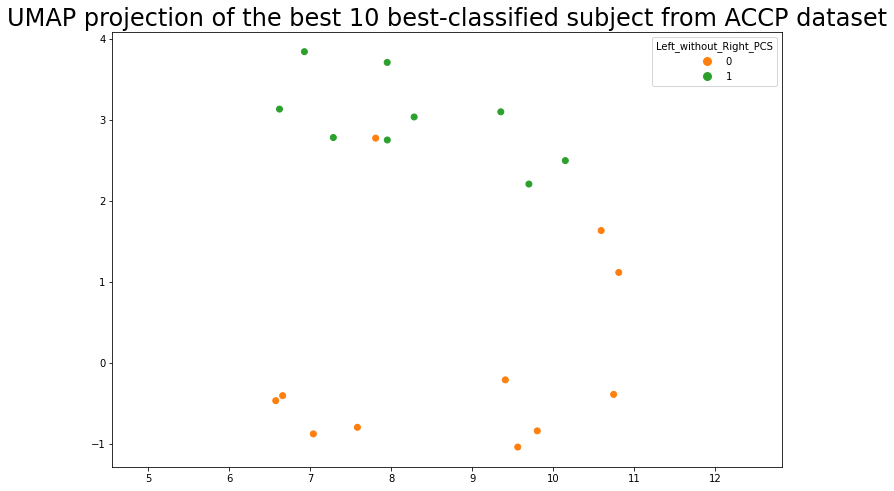

In [559]:
ACCP_proba_pred = model.predict_proba(X)
#ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[0:10]] # top 10 best ranked label 1
#ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[-10:]] # top 10 best ranked label 0
#scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[0:10]] # check if the prediction are also the ground truth (that's a yes)
#scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[-10:]] # check if the prediction are also the ground truth (that's a yes as well)
best_ACCP = pd.concat([scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[-10:]],scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[0:10]]], axis=0)
embedding2D_best_classified_ACCP = reducer.transform(best_ACCP.drop([target,'Dataset','Prediction'], axis=1))
plot_UMAP(embedding2D_best_classified_ACCP, best_ACCP, 'UMAP projection of the best 10 best-classified subject from ACCP dataset', target)


Let's see the SVC borders on the UMAP

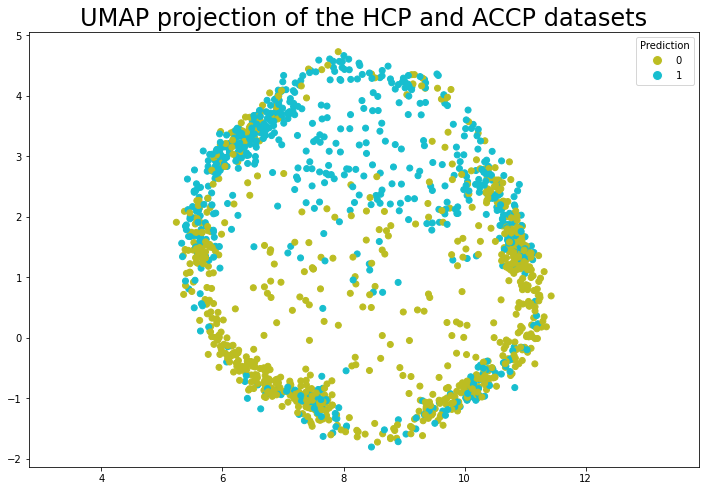

In [560]:
plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACCP datasets', 'Prediction',-2)

We can get the ID of the best classified subject and see in the Anatomist if the paracingular is there or not.

In [561]:
ACCP_proba_pred = model.predict_proba(scd_bdd_hcp.drop([target, 'Dataset', 'Prediction'], axis=1))
ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[0:5]]

array([[0.06257461, 0.93742539],
       [0.06726572, 0.93273428],
       [0.09186339, 0.90813661],
       [0.10257107, 0.89742893],
       [0.10393285, 0.89606715]])

In [562]:
ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[-5:]]

array([[0.98624669, 0.01375331],
       [0.9879317 , 0.0120683 ],
       [0.98832997, 0.01167003],
       [0.98921632, 0.01078368],
       [0.99015657, 0.00984343]])

In [563]:
embeddings_HCP.iloc[ACCP_proba_pred[:,0].argsort()[1114//2-2:1114//2+2]].index

Int64Index([140117, 314225, 143325, 558960], dtype='int64', name='ID')

First 5 people predicted without the target.

In [564]:
embeddings_HCP.iloc[ACCP_proba_pred[:,0].argsort()[-5:]].index

Int64Index([737960, 171330, 173233, 884064, 959574], dtype='int64', name='ID')

First 5 people predicted with the target.

In [565]:
embeddings_HCP.iloc[ACCP_proba_pred[:,0].argsort()[0:5]].index

Int64Index([765864, 927359, 725751, 122620, 172534], dtype='int64', name='ID')

### CSV file generation for SOLAR

In [566]:
df_HCP_binary_pred_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict(X=scl_bdd_hcp)})

df_HCP_binary_pred_PCS.to_csv(f'/neurospin/dico/adufournet/Runs/05_Heritability_Asymmetry_PCS_HCP/Heritability/data/512_pred_{target}.csv', index=False)
df_HCP_binary_pred_PCS.sort_values('IID')

,IID,Pred
0,100206,0
1,100307,0
2,100408,1
3,100610,0
4,101006,0
...,...,...
1109,992774,0
1110,993675,1
1111,994273,1
1112,995174,0


In [567]:
(HCP_asymmetry_PCS['Pred'] == df_HCP_binary_pred_PCS['Pred']).sum()/len(df_HCP_binary_pred_PCS)

0.599640933572711

In [568]:
df_HCP_prob_pred_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict_proba(scl_bdd_hcp)[:,1]})

df_HCP_prob_pred_PCS.to_csv(f'/neurospin/dico/adufournet/Runs/05_Heritability_Asymmetry_PCS_HCP/Heritability/data/512_pred_proba_{target}.csv', index=False)
df_HCP_prob_pred_PCS

,IID,Pred
0,100206,0.190015
1,100307,0.165044
2,100408,0.609418
3,100610,0.282568
4,101006,0.149910
...,...,...
1109,992774,0.152791
1110,993675,0.553522
1111,994273,0.542295
1112,995174,0.103768


In [569]:
target

'Left_without_Right_PCS'